In [103]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster() #processes=7, cores=7
#
w = cluster.scale(jobs=4)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
#Eulerian data
dsU =  xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr',consolidated=False)
dsV =  xr.open_zarr(ut.work_data_dir+'rechunked/SSV_rot.zarr',consolidated=False)

In [4]:
ds_mean = xr.open_zarr(ut.work_data_dir+'diags/mean.zarr')[['SSU','SSV']]
ds_mean

/dev/shm/pbs.1436289.datarmor0/ipykernel_2012/1284874676.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_mean = xr.open_zarr(ut.work_data_dir+'diags/mean.zarr')[['SSU','SSV']]


<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    SSU      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [5]:
ds_mean = ds_mean.drop(['i_g','j_g'])
ds_mean = ds_mean.rename({'i_g':'i','j_g':'j'})
ds_mean = ds_mean.persist()

In [6]:
ds_mean = ds_mean.assign_coords({'XC':dsU.XC,'YC':dsU.YC,'CS':dsU.CS,'SN':dsU.SN})

In [7]:
ds_mean['lon'] = 0*ds_mean.face+ds_mean.XC
ds_mean['lat'] = 0*ds_mean.face+ds_mean.YC

In [8]:
ds_mean['zonal_velocity_mean'] =  ds_mean['SSU']*ds_mean.CS - ds_mean['SSV']*ds_mean.SN
ds_mean['meridional_velocity_mean'] =  ds_mean['SSU']*ds_mean.SN + ds_mean['SSV']*ds_mean.CS

In [9]:
ds_mean = ds_mean.persist()

In [13]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, j: 4320, i: 4320)
Coordinates:
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                         (i) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * j                         (j) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
    XC                        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC                        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    CS                        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN                        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    SSU                       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV                       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    lon                       (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lat                       (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    zonal_velocity_mean       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    meridional_velocity_mean  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [4]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-70., 70., dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [14]:
ds_rot = llcreader.faces_dataset_to_latlon(ds_mean.drop(['SSU','SSV']))


KeyError: 'dxC'

In [15]:
dsU

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, time: 8640)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SSU_rot  (time, face, j, i) float32 dask.array<chunksize=(240, 1, 192, 576), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [5]:
dsU_mean = dsU.mean('time').persist()

In [52]:
dsV_mean = dsV.mean('time').persist()

In [95]:
face,i,j = 11, 2358, 1823
dsi = dsU.isel(face=face,i=i,j=i).persist()

In [96]:
dsiV = dsV.isel(face=face,i=i,j=i).persist()

### Figures Eulerian data

In [97]:
time = dsU.time.values#.compute()
XC = dsU.XC.values#.compute()

In [98]:
time

array(['2011-11-15T00:00:00.000000000', '2011-11-15T01:00:00.000000000',
       '2011-11-15T02:00:00.000000000', ...,
       '2012-11-08T21:00:00.000000000', '2012-11-08T22:00:00.000000000',
       '2012-11-08T23:00:00.000000000'], dtype='datetime64[ns]')

In [68]:
1/48

0.020833333333333332

In [69]:
(XC[0,:])

array([[-114.93228 , -114.93217 , -114.93205 , ...,   64.996376,
          64.99638 ,   64.99639 ],
       [-114.79684 , -114.7965  , -114.79616 , ...,   64.989136,
          64.98915 ,   64.989174],
       [-114.66135 , -114.66078 , -114.66022 , ...,   64.98189 ,
          64.98192 ,   64.98195 ],
       ...,
       [ -37.989582,  -37.96875 ,  -37.947918, ...,   51.947918,
          51.96875 ,   51.989582],
       [ -37.989582,  -37.96875 ,  -37.947918, ...,   51.947918,
          51.96875 ,   51.989582],
       [ -37.989582,  -37.96875 ,  -37.947918, ...,   51.947918,
          51.96875 ,   51.989582]], dtype=float32)

(array(15461.), array(15492.))

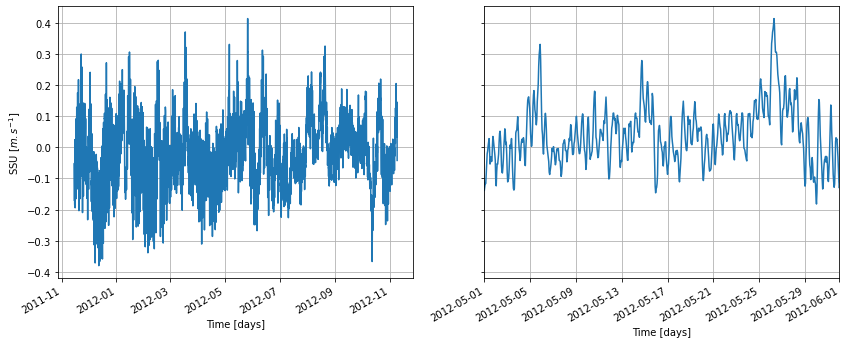

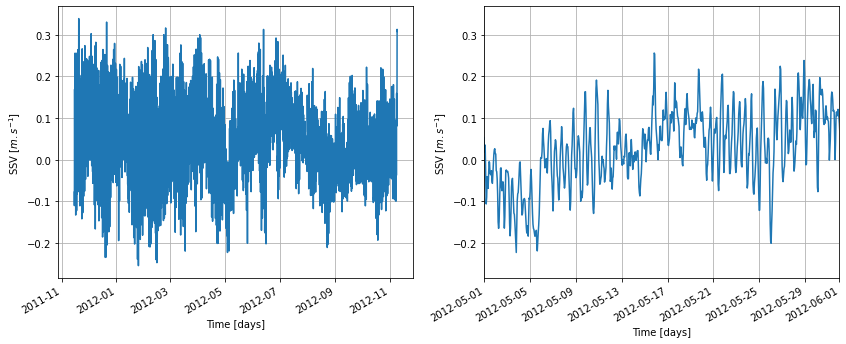

In [101]:
fig,axs = plt.subplots(1,2,figsize=(14,5),sharey=True)
for ax in axs:
    dsi.SSU_rot.plot(ax=ax)
    #dsiV.SSV_rot.plot(ax=ax)
    ax.grid();ax.set_title('');
    ax.set_xlabel('Time [days]');ax.set_ylabel('')
axs[0].set_ylabel(r'SSU [$m.s^{-1}$]')
axs[1].set_xlim('2012-05','2012-06')

fig,axs = plt.subplots(1,2,figsize=(14,5))
for ax in axs:
    dsiV.SSV_rot.plot(ax=ax)
    ax.grid();ax.set_ylabel(r'SSV [$m.s^{-1}$]'),ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[1].set_xlim('2012-05','2012-06')

In [6]:
dsU_mean = dsU_mean.assign_coords({'XC':dsU_mean.XC,'YC':dsU_mean.YC})

In [74]:
dsU_mean['lon'] = 0*dsU_mean.face+dsU_mean.XC
dsU_mean['lat'] = 0*dsU_mean.face+dsU_mean.YC

In [88]:
lon,lat = dsU_mean.sel(face=11).lon.compute(),dsU_mean.sel(face=11).lat.compute()

In [91]:
jlon = lon.where((lon<=-89)&(lon>=-91)&(lat<=-29)&(lat>=-31),drop=True)

In [94]:
print(jlon.j.mean(),jlon.i.mean())

<xarray.DataArray 'j' ()>
array(1823.5)
Coordinates:
    face     int64 11 <xarray.DataArray 'i' ()>
array(2358.5)
Coordinates:
    face     int64 11


In [89]:
_lat = lat.sel(j=jlon,method='nearest')

In [90]:
_lat

ValueError: IndexVariable objects must be 1-dimensional

ValueError: IndexVariable objects must be 1-dimensional

In [7]:
dsU_mean.to_zarr('/home1/datawork/zcaspar/mit4320/'+'ESSU_mean.zarr')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='XC', ylabel='YC'>,
 'cbar': None}

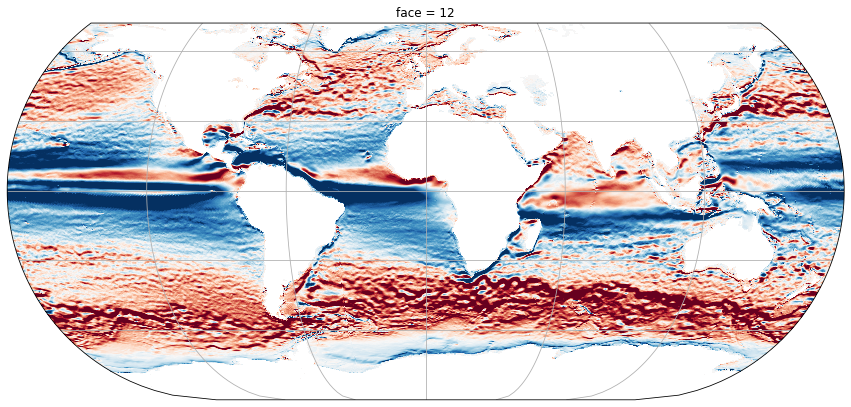

In [53]:
# Map of mean SSU
pl.plot_pretty(dsU_mean.SSU_rot,cmap='RdBu_r',vmax=0.2,vmin=-0.2,land=False,colorbar=False)

In [55]:
dsV_mean = dsV_mean.assign_coords({'XC':dsV_mean.XC,'YC':dsV_mean.YC})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='XC', ylabel='YC'>,
 'cbar': None}

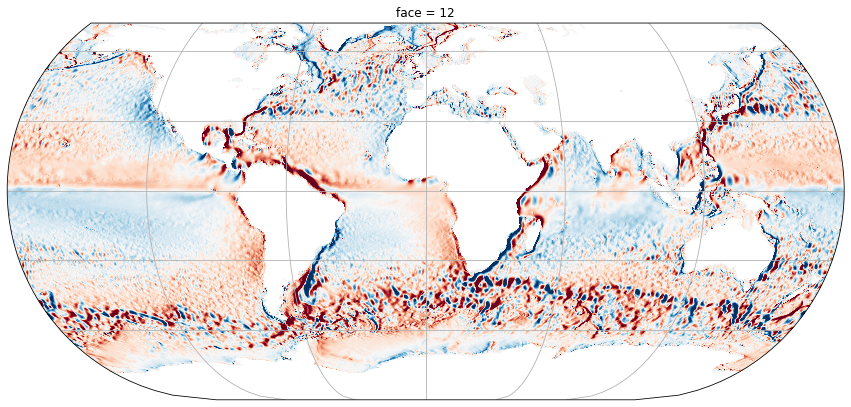

In [56]:
# Map of mean SSV
pl.plot_pretty(dsV_mean.SSV_rot,cmap='RdBu_r',vmax=0.2,vmin=-0.2,land=False,colorbar=False)

In [ ]:
dsU_residual = dsU.SSU_rot-dsU_mean.SSU_rot
dsV_residual = dsV.SSV_rot-dsV_mean.SSV_rot

In [ ]:
ds = xr.merge([dsU,dsV,dsU_residual,dsV_residual])

In [ ]:
MKE = (ds.SSU_rot**2+ds.SSV_rot**2).mean('time').persist()

In [ ]:
EKE = (dsU_residual.SSU_rot**2+ds.SSV_rot**2).mean('time').persist()

In [ ]:
dsV_mean = dsV_mean.assign_coords({'XC':dsV_mean.XC,'YC':dsV_mean.YC})

In [ ]:
# Map of mean SSV
pl.plot_pretty(MKE,cmap='OrRd',vmax=0.1,vmin=0,land=False,colorbar=False)

### Lagrangian data

In [8]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df = pa.degs2ms(df) #Convert in m/s 


### Figures Lagrangian data

In [9]:
t0 = df.index.min().compute()
t0

Timestamp('2011-11-15 00:00:00')

In [38]:
df.index

Dask Index Structure:
npartitions=406
    datetime64[ns]
               ...
         ...      
               ...
               ...
Name: time, dtype: datetime64[ns]
Dask Name: assign, 6902 tasks

In [35]:
df0 = df[[df.index.values==t0]].persist()

ValueError: Cannot call len() on object with unknown chunk size.

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [35]:
traj = df.trajectory.compute()


In [39]:
trajec = np.unique(traj.values)

In [55]:
mean_df = df.groupby('trajectory').mean().persist()

In [57]:
_mean_df = mean_df[['lon','lat']]

In [58]:
_mean_df = _mean_df.compute()

In [65]:
_mean_df[(_mean_df.lon>-95)&(_mean_df.lon<-85)&
        (_mean_df.lat>-35)&(_mean_df.lat<-25)]

,lon,lat
trajectory,,
44000473,-92.811483,-27.557489
44000523,-88.186770,-25.076985
44000549,-89.597445,-25.835262
44000573,-87.448792,-25.206831
44000574,-89.833718,-25.989357
...,...,...
44001791,-90.922148,-33.944895
44001931,-88.390140,-31.313238
44001955,-92.143482,-30.859871


In [66]:
itraj = 44001791

In [67]:
dfi = df[df.trajectory==itraj].persist()

In [68]:
dfi = dfi.compute()

In [69]:
dfi = dfi.reset_index().sort_values('time').set_index('time')

In [70]:
time = dfi.index.values

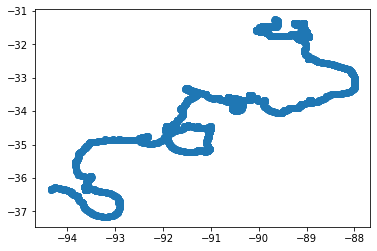

In [71]:
plt.scatter(dfi.lon,dfi.lat)

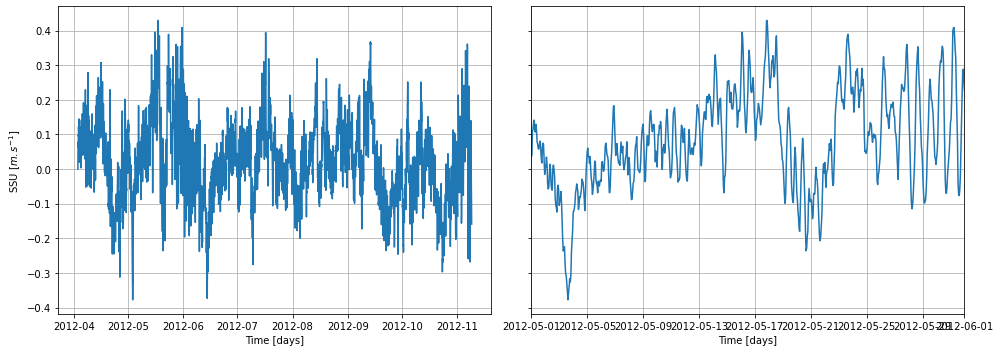

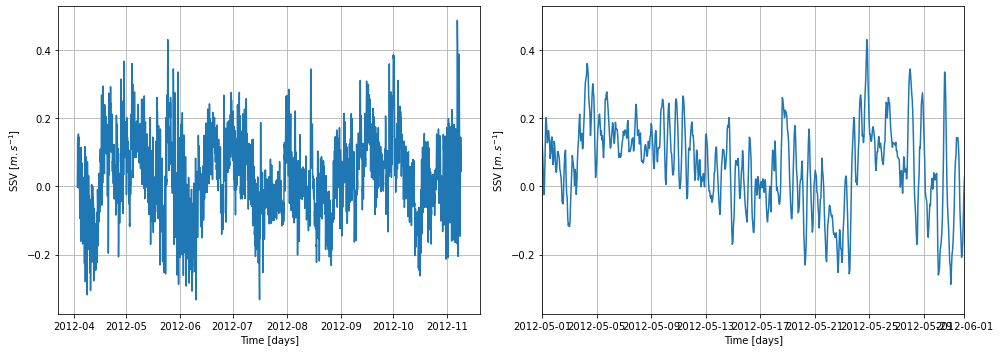

In [72]:
fig,axs = plt.subplots(1,2,figsize=(14,5),sharey=True)
for ax in axs:
    ax.plot(time,dfi.zonal_velocity.values)
    ax.grid();ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[0].set_ylabel(r'SSU [$m.s^{-1}$]')
axs[1].set_xlim('2012-05','2012-06')
fig.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(14,5))
for ax in axs:
    ax.plot(time,dfi.meridional_velocity.values)
    ax.grid();ax.set_ylabel(r'SSV [$m.s^{-1}$]'),ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[1].set_xlim('2012-05','2012-06')
fig.tight_layout()

In [102]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
